In [1]:
import os

import numpy as np
import pandas as pd
from math import erfc, sqrt
from scipy import stats
import statsmodels.api as sm
import scipy.optimize as opt
import warnings

from utils import rouwenhorst
from main import run

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

/Users/chris/PycharmProjects/MehraPrescott/venv/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2. Summary statistics of monthly, annual and quarterly growth

In [2]:
df_month = pd.read_csv("./data/PCE monthly growth data.csv", index_col='date')  # Monthly data
df_quart = pd.read_csv("./data/PCE quarterly growth data.csv", index_col='date')
df_annual = pd.read_excel("./data/PCE growth data.xlsx", index_col='year')

def describe(df, stats):
    d = df.describe()
    return d.append(df.reindex(d.columns, axis = 1).agg(stats))

out = pd.DataFrame()
out1 = {}

for df, name in zip([df_month, df_quart, df_annual], ['Monthly', 'Quarterly', 'Annual']):
    out[name] = describe(df, ['skew', 'kurt'])

    out1[name] = []
    for i in [1,2,3]:
        out1[name].append(df['growth'].autocorr(lag=i))

out1 = pd.DataFrame(out1, index=['AR(1)', 'AR(2)', 'AR(3)'])

out.append(out1).round(4)

,Monthly,Quarterly,Annual
count,743.0000,295.0000,91.0000
mean,0.0015,0.0045,0.0173
std,0.0071,0.0094,0.0220
min,-0.1331,-0.1109,-0.0806
25%,-0.0007,0.0020,0.0099
50%,0.0016,0.0047,0.0203
75%,0.0038,0.0075,0.0305
max,0.0624,0.0751,0.0737
skew,-8.4756,-5.0063,-1.5460
kurt,186.7268,88.6626,5.1247


Lower frequency data (annual) is more persistent than higher frequency data as can be seen by their AR(1) components. Since in the Mehra-Prescott model, $p=\frac{1+\rho}{2}$, then it follows that for $\rho$ close to zero, $p$ will be very close to $0.5$. Thus, for annual data, we can infer that $p>>0.5$ and thus persistence of a Markov Chain will be higher. As a result, all else equal, higher persistence decreases the equity premium in the Mehra-Prescott model. Thus, using the annual data, we expect to find a smaller premium than we would have for monthly data.

## 3.a Reproduce Mehra-Prescott

### Two-state Markov Chain

In [3]:
path_mehra = "./data/Shiller data extended.xlsx"
out, summ = run(n=2, path=path_mehra)

summ

,Mean,Rho,Std
AR coef,0.022761,-0.100142,0.039678
AR moments,1.020689,-0.100142,0.039878
Markov Chain,1.020689,-0.100142,0.039878


### 10-state Markov Chain

In [4]:
out, summ = run(n=10, path=path_mehra)

summ

,Mean,Rho,Std
AR coef,0.022761,-0.100142,0.039678
AR moments,1.020689,-0.100142,0.039878
Markov Chain,1.020689,-0.100142,0.039878


The 10-state chain appear to match the autocorrelation worse than the two-state, which is exact.

## 3.B NIPA Data long sample
### Two-state chain

In [5]:
path_nipa = "./data/PCE growth data.xlsx"
out, summ = run(n=2, path=path_nipa)

summ

,Mean,Rho,Std
AR coef,0.009307,0.4795,0.018700
AR moments,1.017882,0.4795,0.021309
Markov Chain,1.017882,0.4795,0.021309


### 10-state chain

In [6]:
_, summ = run(n=10, path=path_nipa)

summ

,Mean,Rho,Std
AR coef,0.009307,0.4795,0.018700
AR moments,1.017882,0.4795,0.021309
Markov Chain,1.017882,0.4795,0.021309


## 3.C NIPA data post-war
### Two-state chain

In [7]:
_, summ = run(n=2, path=path_nipa, start_year=1950)
summ

,Mean,Rho,Std
AR coef,0.008654,0.493172,0.013500
AR moments,1.017075,0.493172,0.015519
Markov Chain,1.017075,0.493172,0.015519


### 10-state chain

In [8]:
_, summ = run(n=10, path=path_nipa, start_year=1950)
summ

,Mean,Rho,Std
AR coef,0.008654,0.493172,0.013500
AR moments,1.017075,0.493172,0.015519
Markov Chain,1.017075,0.493172,0.015519


## 4.

Unconditional moments are matched in 3.B

In [9]:
# Calibrate chain from data
out, summ = run(n=2, path=path_nipa)
Z, P, pi, mu, sigma, rho = out['Z'], out['P'], out['stationary dist'], out['mean'], out['std'], out['rho']
gamma = 2
beta = np.exp(-0.02)

print("Conditional moments")
cond_mu = P @ Z
cond_std = np.sqrt((P @ Z**2) - cond_mu**2)


pd.DataFrame({'mu': cond_mu,
             'std': cond_std}, index=['Bad State', 'Good State'])

Conditional moments


,mu,std
Bad State,1.007664,0.0187
Good State,1.028099,0.0187


In [10]:
def bond_return(beta, Z=Z, P=P, n=1, gamma=2):
    # Compute risk-free return from Markov Chain
    B_i = np.zeros(2)
    for i in range(2):
        for j in range(2):
            B_i[i] += beta * P[i, j] * Z[j]**(-gamma)
            
    Rf_i = 1/B_i - 1  # Net conditonal risk-free return
    
    B = pi @ Rf_i
    return B

# Solve for the beta that sets bond-return = 0.05 
beta = opt.fsolve(lambda beta: bond_return(beta) - 0.05, x0=np.exp(-0.02))[0]

beta

0.9858463267717397

In [11]:
def Bn_cond_price(beta, Z=Z, P=P, n=1, gamma=2):
    Q = Z * P
    Q_n = np.linalg.matrix_power(Q, n) # Q to the power of n
    return beta**n * np.sum(Q_n, axis=1)  # Sum along rows

def B2_cond_price(beta, Z=Z, P=P, n=1, gamma=2):
    b = np.zeros(n)
    
    for i in range(2):
        for j in range(2):
            for k in range(2):
                b[i] += P[i, j] * Z[j]**(-gamma) * P[j, k] * Z[k] **(-gamma)
    return b * beta**n
                
B2 = B2_cond_price(beta, n=2)
B2

array([0.9354742 , 0.88157146])

In [12]:
def B1_cond_price(beta, Z=Z, P=P, n=1, gamma=2):
    B1 = np.zeros(2)
    for i in range(2):
        for j in range(2):
            B1[i] += beta * P[i, j] * Z[j]**(-gamma)
    return B1

B1 = B1_cond_price(beta)
            
B1

array([0.9718843 , 0.93364498])

In [13]:
h1 = np.zeros(2)
for i in range(2):
    h1[i] = (B1 / B2[i] * P[i, :]).sum() - 1
    
print(f"Bond returns after 1 period: {h1}")
print(f'Bond prices after 1 period: {1/(1+h1)}')

pd.DataFrame({'B1': B1,
             "B2": B2,
             "Holding-return": h1}, index=['Bad State', 'Good State']).T

Bond returns after 1 period: [0.02828332 0.07035764]
Bond prices after 1 period: [0.97249462 0.93426716]


,Bad State,Good State
B1,0.971884,0.933645
B2,0.935474,0.881571
Holding-return,0.028283,0.070358


## Price-Dividend ratio in each state i


In [14]:
def equity_price():
    A = beta * Z**(1-gamma) * P
    b = A.sum(axis=1)

    I = np.identity(2)
    S = np.linalg.inv(I - A) @ b
    return S

S = equity_price()
S

array([32.18727579, 31.00294884])

In [15]:
P_D = S / Z
P_D

array([32.29797004, 29.83374248])

## Return on equity

In [16]:
def return_equity():
    re = np.zeros((2, 2))
    for i in range(2):
        for j in range(2):
            re[j, i] = Z[j]*(S[j]+1)/S[i]-1
    return re

re = return_equity()
re

array([[0.02753442, 0.0667867 ],
       [0.0332396 , 0.07270983]])

In [17]:
# Excess returns
rf = 1/B1 - 1  # 1-period risk-free rate

excess_ret = (re.T - rf).T
excess_ret

array([[-0.00139465,  0.03785764],
       [-0.03783134,  0.00163889]])

## Unconditional moments of excess returns

In [18]:
def uncond_re(re):
    cond_re = (P * re.T).sum(axis=1)
    return pi @ cond_re

re_uncond = uncond_re(re)

uncond_rf = pi @ rf

re_uncond

0.05009376398854559

In [19]:
cond_re = (P * re.T).sum(axis=1)
cond_ER = cond_re - rf

ER_mean = uncond_re(re) - uncond_rf
std = np.sqrt( (pi @ cond_ER**2) - ER_mean**2)
rho1 = np.diag(P)

display(pd.DataFrame([ER_mean, std, rho1, uncond_rf], index=['Mean', 'Std', 'Rho', 'Rf']).T)
print("_"*40)

,Mean,Std,Rho,Rf
0,0.000094,0.000004,"[0.7397501537169731, 0.7397501537169731]",0.05


________________________________________


The unconditional mean of excess returns is practically zero. These findings do not confirm the empirically observed excess returns. It is puzzling that both risk-free returns and equity returns are both high at the same time. In the example, the risk-free rate is at 5\%, so in the data we should expect risk-free rates to be much higher. Thus, it is puzzling risk-free rates are so low empirically.

## Numerical experiment

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

from src.mehra_economy import MehraEconomy
from src.calibrate_mc_from_data import CalibrateMcChainFromData
from src.markov_chain import MarkovChain

plt.rcParams.update({'font.size': 15})



def plot_economy(rf, re, ER, betas, gammas):
    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    #plt.tight_layout()
    fig.subplots_adjust(hspace=.4)

    axs[0, 0].scatter(rf, ER)
    axs[0, 1].scatter(betas, ER)
    axs[1, 0].scatter(gammas, rf, color='b', label='Risk-free')
    axs[1, 0].scatter(gammas, re, color='r', label='Stocks')
    axs[1, 0].legend()

    axs[1, 1].scatter(gammas, ER)

    for ax, xlab, ylab in zip(axs.flatten(), ['Rf', r'$\beta$', r'$\gamma$', r'$\gamma$'],
                              ['Excess Return', 'Excess Return', 'Return', 'Excess Return']):
        ax.set_xlabel(xlab)
        ax.set_title(ylab)

    plt.show()


# Read data and calibrate a Markov chain on an AR(1) process on yearly growth
data = pd.read_excel("./data/PCE growth data.xlsx", index_col="year")
calibration = CalibrateMcChainFromData(data)
mc = calibration()  # Call method returns a MarkovChain


# Initialize economy object
econ = MehraEconomy(mc)
econ.calibrate_beta_to_rf(target_rf=0.05)

### Admissible region of excess returns for differing paris ($\beta$, $\gamma$)

With the constraint that risk-free returns $\in (0, 0.04)$

The data is not able to reconstruct the empirical data. No combination of $\beta$ and $\gamma$ is able to match observed excess returns. Finally, the results here are quite different from those in the Mehra-Prescott paper, but this is due to them having a negative annual autocorrelation, whereas ours is positive. For a replication of their results see the final section. 

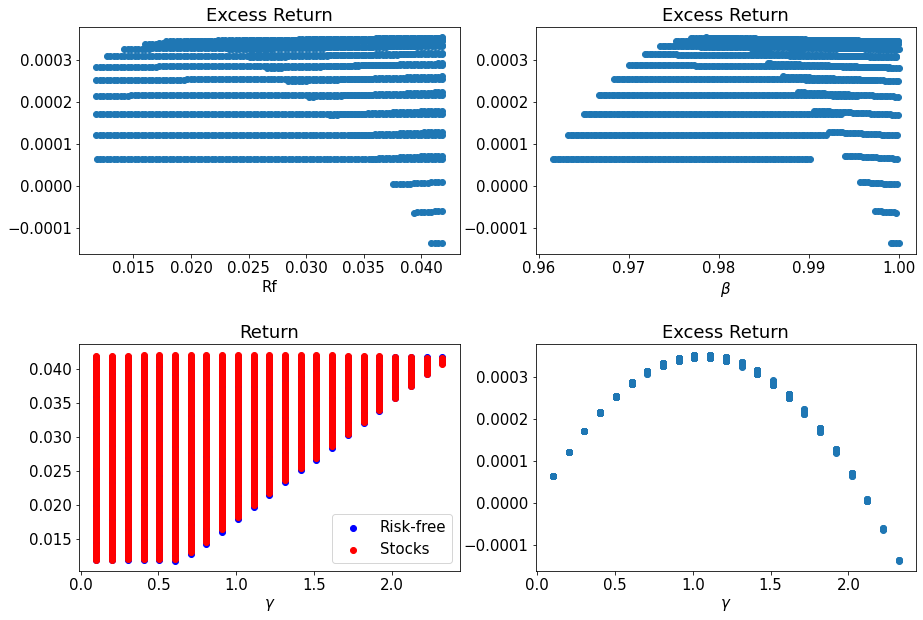

In [21]:
N = 100
ER, rf, re, betas, gammas = econ.num_experiment(N=N)
plot_economy(rf, re, ER, betas, gammas)

### Repeating above experiment, without the constraint that Rf>0.04

From the plot, it is evident that equity returns are increasing in $\gamma$, however so is the risk-free rate, which is even increasing faster than equity returns. Thus resulting in a negative excess return.

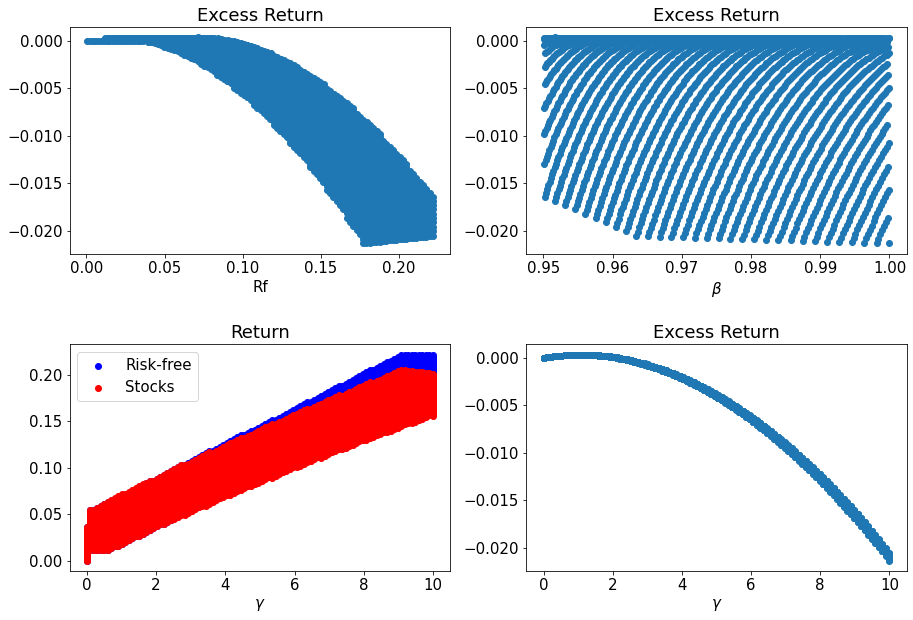

In [22]:
ER, rf, re, betas, gammas = econ.num_experiment(N=N, rf_bound=(0.01, 0.22))
plot_economy(rf, re, ER, betas, gammas)

## Appendix: Replicating Mehra-Prescotts Figure 4

Upper left corner corresponds to their original figure 4. Interestingly, with their parameters the excess returns are now increasing in $\gamma$ and not decreasing. This is because, as mentioned, now the autocorrelation is negative.

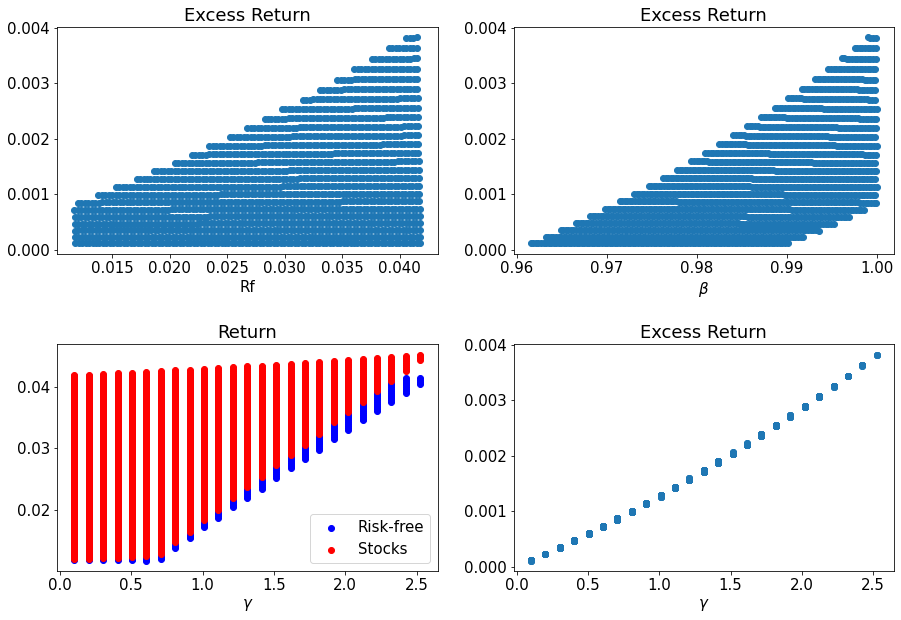

In [23]:
p = 0.43
x = np.array([ 1 +0.018 - 0.036, 1+ 0.018 + 0.036])
mc = MarkovChain(Pi=np.array([[p, 1 - p], [1 - p, p]]), x=x)

# Initialize economy object
econ = MehraEconomy(mc)
econ.calibrate_beta_to_rf(target_rf=0.05)

# Plot
ER, rf, re, betas, gammas = econ.num_experiment(N=N)
plot_economy(rf, re, ER, betas, gammas)